In [ ]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import PIL.Image as Image
from IPython.display import display

In [ ]:
data_dir='/content/drive/MyDrive/ColabNotebooks/cardir'
train_dir = '/content/drive/MyDrive/ColabNotebooks/cardir/train'
valid_dir = '/content/drive/MyDrive/ColabNotebooks/cardir/valid'
test_dir ='/content/drive/MyDrive/ColabNotebooks/cardir/test'

In [ ]:
# Training transform includes random rotation and flip to build a more robust model
train_transforms = transforms.Compose([transforms.Resize((244,244)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# The validation set will use the same transform as the test set
test_transforms = transforms.Compose([transforms.Resize((244,244)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

validation_transforms = transforms.Compose([transforms.Resize((244,244)),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms,
                                  loader=lambda x: Image.open(x).convert('RGB'))
valid_data = datasets.ImageFolder(valid_dir, transform=validation_transforms,
                                  loader=lambda x: Image.open(x).convert('RGB'))
test_data = datasets.ImageFolder(test_dir, transform=test_transforms,
                                 loader=lambda x: Image.open(x).convert('RGB'))

# The trainloader will have shuffle=True so that the order of the images do not affect the model
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = models.resnet34(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 261MB/s]


In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [ ]:
# Implement a function for the validation pass
def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    # change model to work with cuda
    model.to('cuda')
    # Iterate over data from validloader
    for ii, (images, labels) in enumerate(validloader):
        # Change images and labels to work with cuda
        images, labels = images.to('cuda'), labels.to('cuda')
        # Forward pass image though model for prediction
        output = model.forward(images)
        # Calculate loss
        valid_loss += criterion(output, labels).item()
        # Calculate probability
        ps = torch.exp(output)

        # Calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return valid_loss, accuracy

In [ ]:
epochs = 8
steps = 0
print_every = 40

# change to gpu mode
model.to('cuda')
model.train()
for e in range(epochs):

    running_loss = 0
    train_accuracy = 0
    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1

        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # zeroing parameter gradients
        optimizer.zero_grad()

        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        ps = torch.exp(outputs)
        equality = (labels.data == ps.max(dim=1)[1])
        train_accuracy += equality.type(torch.FloatTensor).mean()
        # Carrying out validation step
        if steps % print_every == 0:
            # setting model to evaluation mode during validation
            model.eval()

            # Gradients are turned off as no longer in training
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)

            print(f"No. epochs: {e+1}, \
            Training Loss: {round(running_loss/print_every,3)} \
            Training Accuracy: {round(float(train_accuracy/print_every),3)}\
            Valid Loss: {round(valid_loss/len(validloader),3)} \
            Valid Accuracy: {round(float(accuracy/len(validloader)),3)}")


            # Turning training back on
            model.train()
            lrscheduler.step(accuracy * 100)

No. epochs: 1,             Training Loss: 5.178             Training Accuracy: 0.029            Valid Loss: 4.643             Valid Accuracy: 0.078
No. epochs: 2,             Training Loss: 2.187             Training Accuracy: 0.115            Valid Loss: 3.558             Valid Accuracy: 0.196
No. epochs: 3,             Training Loss: 0.394             Training Accuracy: 0.066            Valid Loss: 2.662             Valid Accuracy: 0.338
No. epochs: 3,             Training Loss: 2.619             Training Accuracy: 0.561            Valid Loss: 2.031             Valid Accuracy: 0.468
No. epochs: 4,             Training Loss: 1.15             Training Accuracy: 0.467            Valid Loss: 1.636             Valid Accuracy: 0.565
No. epochs: 5,             Training Loss: 0.333             Training Accuracy: 0.224            Valid Loss: 1.583             Valid Accuracy: 0.577
No. epochs: 5,             Training Loss: 1.271             Training Accuracy: 1.019            Valid Loss: 1.267

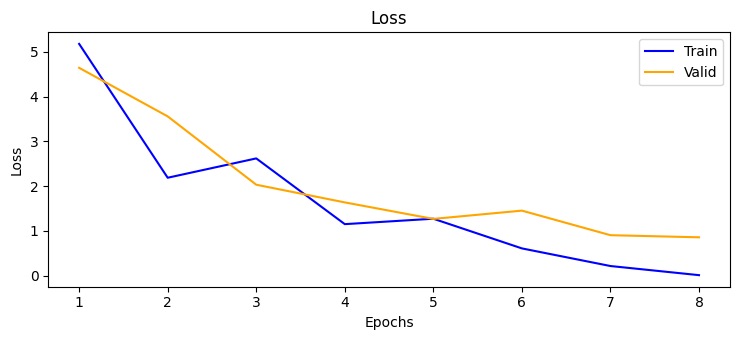

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
x=np.array([1,2,3,4,5,6,7,8])
Train = np.array([5.178, 2.187, 2.619, 1.15, 1.271, 0.608, 0.214, 0.01])
Valid = np.array([4.643, 3.558, 2.031, 1.636, 1.267, 1.452, 0.903, 0.856 ])

ax1 = plt.subplot()
l1, = ax1.plot(x, Train, color='Blue')
l2, = ax1.plot(x, Valid, color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
plt.legend([l1, l2], ["Train", "Valid"])
plt.title("Loss")
plt.show()

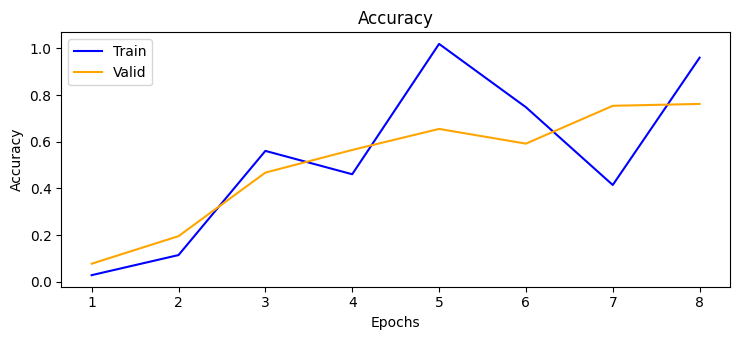

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
x=np.array([1,2,3,4,5,6,7,8])
Train = np.array([0.029, .115, .561, .461, 1.019, .748, .415, .96])
Valid = np.array([.078, .196, .468, .565, .655, .592, .754, .762 ])

ax1 = plt.subplot()
l1, = ax1.plot(x, Train, color='Blue')
l2, = ax1.plot(x, Valid, color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
plt.legend([l1, l2], ["Train", "Valid"])
plt.title("Accuracy")
plt.show()

In [ ]:
correct = 0
total = 0
model.to('cuda')


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        # Get probabilities
        outputs = model(images)
        # Turn probabilities into predictions
        _, predicted_outcome = torch.max(outputs.data, 1)
        # Total number of images
        total += labels.size(0)
        # Count number of cases in which predictions are correct
        correct += (predicted_outcome == labels).sum().item()

print(f"Test accuracy of model: {round(100 * correct / total,3)}%")

Test accuracy of model: 65.241%


In [ ]:
checkpoint = {'state_dict': model.state_dict(),
              'model': model.fc,
              'class_to_idx': train_data.class_to_idx,
              'opt_state': optimizer.state_dict,
              'num_epochs': epochs}

torch.save(checkpoint, '/content/drive/MyDrive/ColabNotebooks/my_resnetcheckpoint.pth')

In [ ]:
def load_checkpoint(filepath):

    checkpoint = torch.load(filepath)

    #model.load_state_dict(checkpoint['state_dict'])
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.class_to_idx = checkpoint['class_to_idx']

    return model

In [ ]:
model = load_checkpoint('/content/drive/MyDrive/ColabNotebooks/my_checkpoint1.pth')
# Checking model i.e. should have 196 output units in the classifier
print(model)

In [ ]:
model = torch.nn.DataParallel(model)

In [ ]:
def process_image(image):

    # Process a PIL image for use in a PyTorch model

    # Converting image to PIL image using image file path
    pil_im = Image.open(f'{image}' + '.jpg')

    # Building image transform
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])

    # Transforming image for use with network
    pil_tfd = transform(pil_im)

    # Converting to Numpy array
    array_im_tfd = np.array(pil_tfd)

    return array_im_tfd

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

In [ ]:
def predict(image_path, model, topk=5):
    # Implement the code to predict the class from an image file

    # Loading model
    loaded_model = load_checkpoint(model)
    # Moving the loaded model to the GPU
    loaded_model.cuda()
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Moving the input tensor to the GPU
    img_tensor = img_tensor.cuda()
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)
    input=Variable(img_add_dim)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)
    probs_top = output.topk(topk)[0]
    predicted_top = output.topk(topk)[1]
     # Converting probabilities and outputs to lists
    conf = np.array(probs_top.cpu())[0]
    predicted = np.array(predicted_top.cpu())[0]
    return conf, predicted



In [ ]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(train_dir)

print(classes, c_to_idx)

In [ ]:
def plot_solution(cardir, model):
  # Testing predict function

  # Inputs are paths to saved model and test image
  model_path = '/content/drive/MyDrive/ColabNotebooks/my_resnetcheckpoint.pth'
  image_path = test_dir+cardir
  carname = cardir.split('/')[1]

  conf2, predicted1 = predict(image_path, model_path, topk=5)
  # Converting classes to names
  names = []
  for i in range(5):

      names += [classes[predicted1[i]]]
  # Creating PIL image
  image = Image.open(image_path+'.jpg')
  # Plotting test image and predicted probabilites
  f, ax = plt.subplots(2,figsize = (6,10))

  ax[0].imshow(image)
  ax[0].set_title(carname)

  y_names = np.arange(len(names))
  ax[1].barh(y_names, conf2/conf2.sum(), color='darkblue')
  ax[1].set_yticks(y_names)
  ax[1].set_yticklabels(names)
  ax[1].invert_yaxis()

  plt.show()

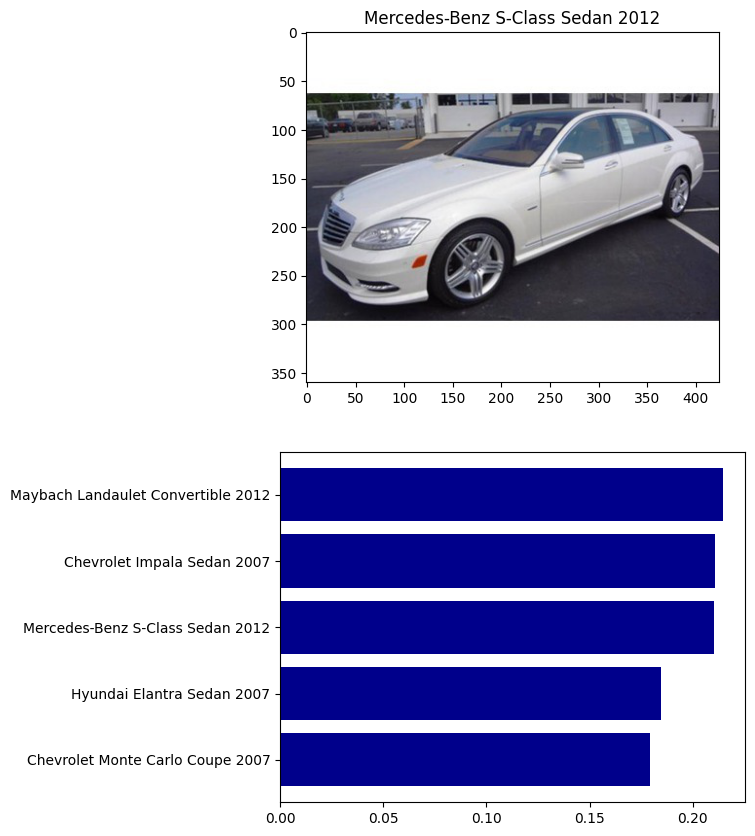

In [ ]:
cardir='/Mercedes-Benz S-Class Sedan 2012/06543'
plot_solution(cardir , model)

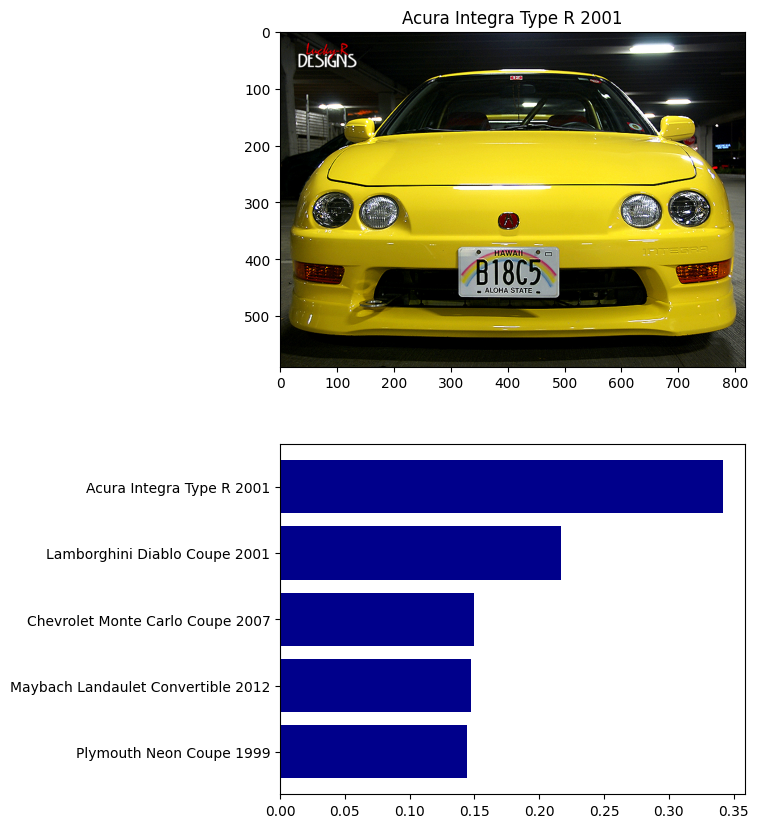

In [ ]:
cardir='/Acura Integra Type R 2001/06181'
plot_solution(cardir , model)



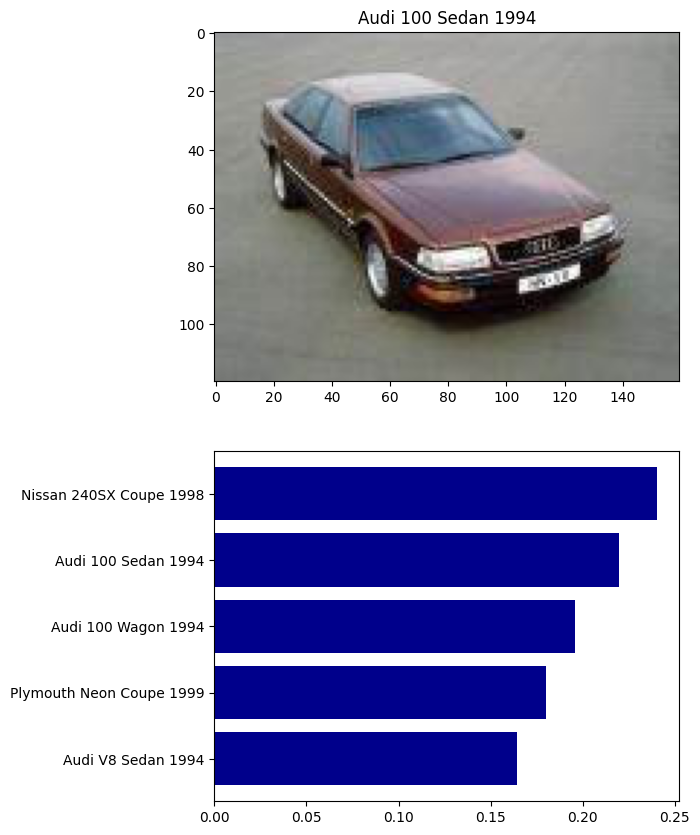

In [ ]:
cardir='/Audi 100 Sedan 1994/00082'
plot_solution(cardir , model)

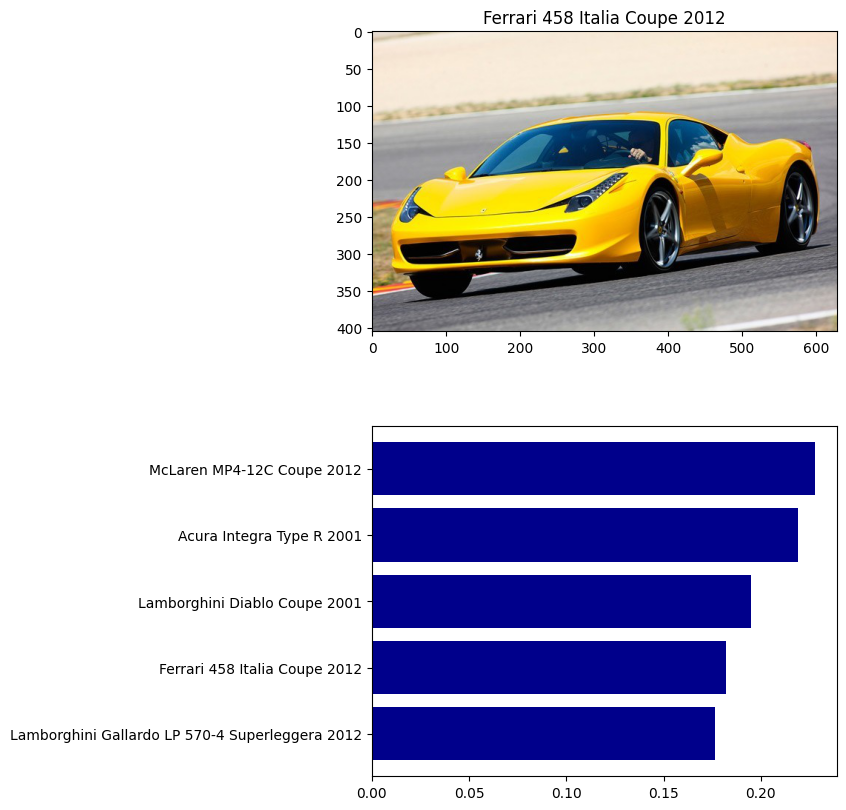

In [ ]:
cardir='/Ferrari 458 Italia Coupe 2012/07358'
plot_solution(cardir , model)